In [1]:
import json, copy, datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# February 26, 2023
# git commit 78487be4394a2d27f446d05b697b2e5bcfb263b7
from agent_model import AgentModel
from jupyter_scripts import plot_agent, parse_data

# Helper functions for loading config and data files
valid_missions = {'1h', '1hg_sam', '1hrad', '4h', '4hg', 'b2_mission1a', 'b2_mission1b', 'b2_mission2'}
cache = dict(config={}, data={})
def get_config(mission):
    assert mission in valid_missions, f'Unrecognized mission: {mission}'
    if mission not in cache['config']:
        with open(f'data_files/config_{mission}.json') as f:
            config = json.load(f)
        cache['config'][mission] = config
    return copy.deepcopy(cache['config'][mission])
def get_data(mission):
    assert mission in valid_missions, f'Unrecognized mission: {mission}'
    if mission not in cache['data']:
        simdata_id = {
            '1h': '1-human-preset',
            '1hg_sam': 'sam-1-human-garden-preset',
            '1hrad': '1-human-radish-preset',
            '4hg': '4-human-garden-preset',
            '4h': '4-human-preset',
            'b2_mission1a': 'b2-mission-1a',
            'b2_mission1b': 'b2-mission-1b',
            'b2_mission2': 'b2-mission-2',
        }[mission]
        path = f'../simoc-web/public/simdata/simoc-simdata-{simdata_id}.json'
        with open(path) as f:
            simdata = json.load(f)
        cache['data'][mission] = simdata['data']
    return copy.deepcopy(cache['data'][mission])
with open('data_files/agent_desc.json') as f:
    agent_desc = json.load(f)

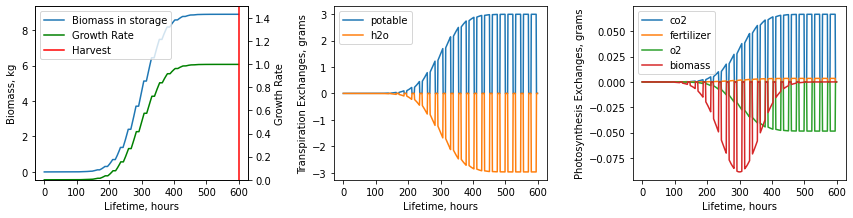

In [2]:
# Figure 1: SIMOC plant growth
def plot_plant_growth(model, data, plant_name, i=None, j=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    fig.tight_layout()

    i = 0 if i is None else i
    j = data['step_num'] if j is None else j
    plant = model.get_agents_by_type(plant_name)[0]
    lifetime = plant.attrs['char_lifetime']
    
    # Growth Rate
    total_biomass = parse_data(data, [plant_name, 'storage', 'biomass', f'{i}:{j}'])
    axs[0].plot(total_biomass, label='Biomass in storage')
    growth_rate = parse_data(data, [plant_name, 'growth', 'growth_rate', f'{i}:{j}'])
    ax2 = axs[0].twinx()
    ax2.set_ylim([0, 1.5])
    ax2.plot(growth_rate, color='green', label='Growth Rate')
    ax2.axvline(lifetime, color='red', label='Harvest')
    axs[0].set_ylabel('Biomass, kg')
    ax2.set_ylabel('Growth Rate')
    axs[0].set_xlabel('Lifetime, hours')
    
    lines, labels = axs[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[0].legend(lines + lines2, labels + labels2, loc='upper left')

    # Transpiration
    inputs = parse_data(data, [plant_name, 'flows', 'in', 'potable', 'SUM', f'{i}:{j}'])
    axs[1].plot(inputs, label='potable')
    outputs = parse_data(data, [plant_name, 'flows', 'out', 'h2o', 'SUM', f'{i}:{j}'])
    axs[1].plot([-_o for _o in outputs], label='h2o')
    axs[1].set_ylabel('Transpiration Exchanges, grams')
    axs[1].set_xlabel('Lifetime, hours')
    axs[1].legend(loc='upper left')

    # Photosynthesis
    inputs = parse_data(data, [plant_name, 'flows', 'in', 'co2,fertilizer', 'SUM', f'{i}:{j}'])
    for k, v in inputs.items():
        axs[2].plot(v, label=k)
    outputs = parse_data(data, [plant_name, 'flows', 'out', 'o2,biomass', 'SUM', f'{i}:{j}'])
    for k, v in outputs.items():
        axs[2].plot([-_o for _o in v], label=k)
    axs[2].set_ylabel('Photosynthesis Exchanges, grams')
    axs[2].legend(loc='upper left')
    axs[2].set_xlabel('Lifetime, hours')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    
    plt.show()
    
config = get_config('1hrad')
model = AgentModel.from_config(**config)
model.step_to(n_steps=600)
data = model.get_data()
plot_plant_growth(model, data, 'radish')

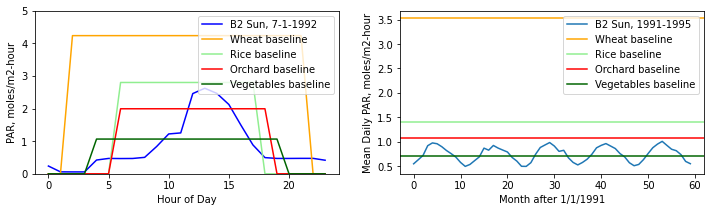

In [9]:
from agent_model.agents.custom_funcs import hourly_par_fraction, monthly_par

# Figure 2: B2-Sun PAR production vs ideal
config_m1a = get_config('b2_mission1a')
model_m1a = AgentModel.from_config(**config_m1a)
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Daily PAR for, July, 1992
sun_daily = np.array(hourly_par_fraction) * monthly_par[18]
axs[0].plot(sun_daily, color='blue', label='B2 Sun, 7-1-1992')
axs[0].set_ylabel('PAR, moles/m2-hour')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylim([0, 5])

# Monthly PAR for full date range
axs[1].plot(monthly_par, label='B2 Sun, 1991-1995')
axs[1].set_ylabel('Mean Daily PAR, moles/m2-hour')
axs[1].set_xlabel('Month after 1/1/1991')

# Add plants
for (crop, color) in [('wheat', 'orange'), ('rice', 'lightgreen'), ('orchard', 'red'), ('vegetables', 'darkgreen')]:
    agent = model_m1a.get_agents_by_type(crop)[0]
    par_baseline = agent.attrs['char_par_baseline']
    daily_growth = np.array(agent.daily_growth) * par_baseline
    axs[0].plot(daily_growth, color=color, label=f'{crop.capitalize()} baseline')
    axs[1].axhline(par_baseline, color=color, label=f'{crop.capitalize()} baseline')
    
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

beginning on 1989-07-01 00:00:00


Text(0.5, 0, 'Date')

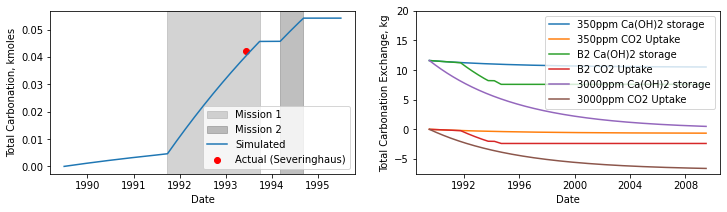

In [4]:
import datetime
import pandas as pd

# Simulate the actual lifetime of the concrete at b2
schedule = dict(
    poured=dict(date=datetime.datetime(1989, 7, 1), ppm=350),
    m1_start=dict(date=datetime.datetime(1991, 9, 26), ppm=3000),
    measured=dict(date=datetime.datetime(1993, 6, 7), ppm=3000),
    m1_end=dict(date=datetime.datetime(1993, 9, 25), ppm=350),
    m2_start=dict(date=datetime.datetime(1994, 3, 6), ppm=3000),
    m2_end=dict(date=datetime.datetime(1994, 9, 7), ppm=350),
    end=dict(date=datetime.datetime(2009, 6, 30)),
)

# Setup a dummy agent to run 20 years (without the model), using values from M1a.
concrete = model_m1a.get_agents_by_type('concrete')[0]
class DummyConcrete:
    def __init__(self):
        self.carbonation_rate = 0
        self.carbonation = 0
        self.caoh2 = concrete.calc_max_carbonation(3000) * concrete.attrs['in_caoh2']
        self.co2 = 0
        self.cao3 = 0
        self.moisture = 0
        
        self.records = {d: [getattr(self, d)] for d in {'carbonation_rate', 'carbonation', 'caoh2', 'co2', 'cao3', 'moisture'}}
    
    def step(self, ppm):
        max_carbonation = concrete.calc_max_carbonation(ppm)
        gradient = max(0, max_carbonation - self.carbonation)
        
        self.carbonation_rate = gradient * concrete.diffusion_rate
        self.carbonation += self.carbonation_rate
        self.caoh2 -= self.carbonation_rate * concrete.attrs['in_caoh2']
        self.co2 -= self.carbonation_rate * concrete.attrs['in_co2']
        self.cao3 += self.carbonation_rate * concrete.attrs['out_caco3']
        self.moisture += self.carbonation_rate * concrete.attrs['out_moisture']
        
        for key, records in self.records.items():
            records.append(getattr(self, key))
            
low_concrete = DummyConcrete()
b2_concrete = DummyConcrete()
high_concrete = DummyConcrete()
for i, (k, v) in enumerate(schedule.items()):
    if i == 0:
        print('beginning on', v['date'])
    else:
        prev = list(schedule.values())[i-1]
        n_steps = (v['date'] - prev['date']).days
        for i in range(n_steps * 24):
            b2_concrete.step(prev['ppm'])
            low_concrete.step(350)
            high_concrete.step(3000)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
steps = pd.date_range(start=schedule['poured']['date'], end=schedule['end']['date'], freq='H')
def shade_missions(ax):
    ax.axvspan(schedule['m1_start']['date'], schedule['m1_end']['date'], alpha=0.5, color='darkgray', label='Mission 1')
    ax.axvspan(schedule['m2_start']['date'], schedule['m2_end']['date'], alpha=0.5, color='gray', label='Mission 2')
    
fig_range = 6 * 365 * 24  # 6 years
# axs[0].plot(steps[:fig_range], b2_concrete.records['carbonation_rate'][:fig_range], label='Simulated')
# shade_missions(axs[0])
# axs[0].legend(loc='lower right')
# axs[0].set_ylabel('Carbonation Rate, kmoles/m2-hour')
# axs[0].set_xlabel('Date')

shade_missions(axs[0])
axs[0].plot(steps[:fig_range], b2_concrete.records['carbonation'][:fig_range], label='Simulated')
axs[0].scatter(x=schedule['measured']['date'], y=550/13000, color='red', label='Actual (Severinghaus)')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Total Carbonation, kmoles')
axs[0].set_xlabel('Date')

datasets = [
    ('350ppm', low_concrete.records), 
    ('B2', b2_concrete.records), 
    ('3000ppm', high_concrete.records),
]
for (label, records) in datasets:
    axs[1].plot(steps, records['caoh2'], label=f'{label} Ca(OH)2 storage')
    axs[1].plot(steps, records['co2'], label=f'{label} CO2 Uptake')
axs[1].set_ylim([-7.5, 20])
axs[1].legend()
axs[1].set_ylabel('Total Carbonation Exchange, kg')    
axs[1].set_xlabel('Date')
    
# # Concrete
# config = get_config('1h')
# config_m1a = get_config('b2_mission1a')
# config['config']['agents']['concrete'] = dict(amount=1)
# config_m1a['agent_desc']['eclss']['co2_removal_SAWD']

[]

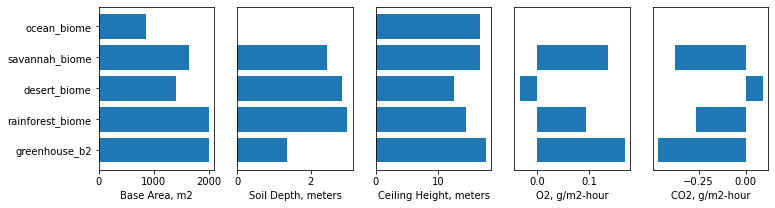

In [10]:
# Biomes
biomes = ['greenhouse_b2', 'rainforest_biome', 'desert_biome', 
          'savannah_biome', 'ocean_biome']
labels = ['Base Area', 'Soil Depth, meters', 'Ceiling Height, meters', 'O2 Exchange, kg', 'CO2 exchange, kg']
base_area = []
soil_depth = []
ceiling_height = []
co2 = []
o2 = []
for biome in biomes:
    agent = model_m1a.get_agents_by_type(biome)[0]
    base_area.append(agent.amount)
    soil_depth.append(agent.attrs.get('char_soil', 0))
    ceiling_height.append(agent.attrs['char_volume'])
    co2_exchange = 0
    o2_exchange = 0
    for attr in agent.attrs:
        prefix, currency = attr.split('_', 1)
        multiplier = 1 if prefix == 'in' else -1
        if currency == 'co2' and prefix in {'in', 'out'}:
            co2_exchange = agent.attrs[attr] * multiplier
        elif currency == 'o2' and prefix in {'in', 'out'}:
            o2_exchange = agent.attrs[attr] * multiplier
    co2.append(co2_exchange)
    o2.append(o2_exchange)                       

fig, axs = plt.subplots(1, len(labels), figsize=(12, 3))
axs[0].barh(biomes, base_area)
axs[0].set_xlabel('Base Area, m2')
axs[1].barh(biomes, soil_depth)
axs[1].set_xlabel('Soil Depth, meters')
axs[1].set_yticks([])
axs[2].barh(biomes, ceiling_height)
axs[2].set_xlabel('Ceiling Height, meters')
axs[2].set_yticks([])
axs[3].barh(biomes, [o*1000 for o in o2])
axs[3].set_xlabel('O2, g/m2-hour')
axs[3].set_yticks([])
axs[4].barh(biomes, [c*1000 for c in co2])
axs[4].set_xlabel('CO2, g/m2-hour')
axs[4].set_yticks([])

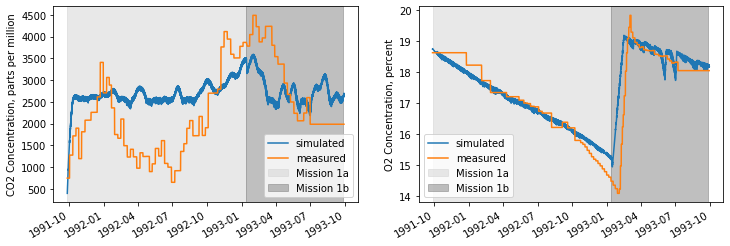

In [6]:
# Load Co2 and O2 Measurements
dirname = 'simoc_server/test/b2_data_files/'
def read_and_add_datetime(currency):
    df = pd.read_csv(f'{dirname}severinghaus_{currency}_datapoints.csv', header=None)
    df.columns = ['julian', 'measurement']
    time_delta = pd.to_timedelta(df['julian'], unit='D')
    df['timestamp'] = schedule['m1_start']['date']
    df['timestamp'] += time_delta
    df.set_index('timestamp', inplace=True)
    df.drop('julian', axis=1, inplace=True)
    return df

# Get simulated levels for missions 1a and 1b
data_m1a = get_data('b2_mission1a')
data_m1b = get_data('b2_mission1b')
def merge_data_add_datetime(currency):
    _1a = parse_data(data_m1a, ['greenhouse_b2', 'storage_ratios', currency, '*'])
    _1b = parse_data(data_m1b, ['greenhouse_b2', 'storage_ratios', currency, '*'])
    index_1a = pd.date_range(start=schedule['m1_start']['date'], periods=len(_1a), freq='H')
    index_1b = pd.date_range(start=index_1a[-1] + datetime.timedelta(days=2), periods=len(_1b), freq='H')
    df = pd.concat([pd.DataFrame(_1a, columns=['simulated'], index=index_1a),
                    pd.DataFrame(_1b, columns=['simulated'], index=index_1b)], axis=0)
    measured = read_and_add_datetime(currency)
    df['i_measured'] = measured.index.get_indexer(df.index, method='nearest')
    df['measured'] = df['i_measured'].apply(lambda i: measured.iloc[i])
    df.drop('i_measured', inplace=True, axis=1)
    return df
        
m1a_start = schedule['m1_start']['date']
m1b_start = datetime.datetime(1993, 1, 12)
m1_end = schedule['m1_end']['date']
def shade_missions(ax):
    ax.axvspan(m1a_start, m1b_start-datetime.timedelta(days=1), alpha=0.5, color='lightgray', label='Mission 1a')
    ax.axvspan(m1b_start, m1_end, alpha=0.5, color='gray', label='Mission 1b')
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
co2 = merge_data_add_datetime('co2')
co2.loc[:, ['simulated', 'measured']] *= 1000000
co2.plot(ax=axs[0])
axs[0].set_ylabel('CO2 Concentration, parts per million')
shade_missions(axs[0])
axs[0].legend()

o2 = merge_data_add_datetime('o2')
o2.loc[:, ['simulated', 'measured']] *= 100
o2.plot(ax=axs[1])
axs[1].set_ylabel('O2 Concentration, percent')
shade_missions(axs[1])
axs[1].legend()

In [7]:
# # Yields, Mission measured vs simulated
# missions = ['CELSS', 'Mission 2', 'Mission 1b', 'Mission 1a']
# plants = ['wheat', 'rice', 'corn', 'sorghum']
# labels = ['Simulated', 'Measured']

# # Input measured data manually from Marino Table 3
# yields = {'simulated': {p: [] for p in plants},
#           'measured': {
#             'sorghum': [0, .0038, .0016, .0017],
#             'corn': [0, .0039, 0, 0],
#             'rice': [0, .006, .0016, .0023],
#             'wheat': [0, .003, .0012, .0017]}}

# # Simulate the reference crops under ideal conditions. Start with preset
# # 4-human garden. Remove stock plants except wheat; clone wheat to create 
# # 3 new plants, add lamps, connections, etc.
# config = get_config('4hg')
# for plant in {'cabbage', 'strawberry', 'radish', 'red_beet', 'onion'}:
#     del config['config']['agents'][plant]
#     del config['config']['agents'][f'{plant}_lamp']
#     del config['agent_desc']['structures'][f'{plant}_lamp']
# config['config']['agents']['wheat']['amount'] = 10
# config['config']['agents']['wheat_lamp']['amount'] = 10
# for plant in {'corn', 'rice', 'sorghum'}:
#     plant_agent = copy.deepcopy(config['config']['agents']['wheat'])
#     lamp_agent = copy.deepcopy(config['config']['agents']['wheat_lamp'])
#     lamp_desc = copy.deepcopy(config['agent_desc']['structures']['wheat_lamp'])
#     plant_par = next(c['value'] for c in agent_desc['plants'][plant]['data']['characteristics']
#                      if c['type'] == 'par_baseline')
#     for i, char in enumerate(lamp_desc['data']['characteristics']):
#         if char['type'] == 'par_baseline':
#             lamp_desc['data']['characteristics'][i]['value'] = plant_par
#     config['config']['agents'][plant] = plant_agent
#     config['config']['agents'][f'{plant}_lamp'] = lamp_agent
#     config['agent_desc']['structures'][f'{plant}_lamp'] = lamp_desc
#     config['agent_conn'].append({'from': f'{plant}_lamp.par', 'to': f'{plant}.par'})
#     config['agent_conn'].append({'from': f'{plant}_lamp.par', 'to': f'{plant}_lamp.par'})
#     config['agent_conn'].append({'from': 'power_storage.kwh', 'to': f'{plant}_lamp.kwh'})
# ref_model = AgentModel.from_config(**config)
# ref_model.step_to(termination=True)
# ref_data = ref_model.get_data()

# # Pull simulation mean production for each crop
# for i, mission in enumerate(['ref', 'b2_mission2', 'b2_mission1b', 'b2_mission1a']):
#     if mission == 'ref':
#         simdata = ref_data
#     else:
#         simdata = get_data(mission)
#     for plant in plants:
#         path = [plant, 'flows', 'out', plant, 'SUM', '*']
#         production = parse_data(simdata, path)
#         value = (sum(production)               # Total output
#                  / simdata[plant]['amount'][0]  # per m2
#                  / (len(production) / 24))     # daily
#         yields['simulated'][plant].append(value)
                
fig, axs = plt.subplots(1, len(plants), figsize=(12, 3))
for i, (plant, ax) in enumerate(zip(plants, axs)):
    ind = np.arange(len(missions))
    width = 0.4
    y_sim = yields['simulated'][plant]
    y_mea = yields['measured'][plant]
    ax.barh(ind+0.5*width, y_sim, width, color='blue', label='Simulated')
    ax.barh(ind+1.5*width, y_mea, width, color='orange', label='Measured')
    errors = [0 if _m == 0 else (_m-_s)/_m for _m, _s in zip(y_mea, y_sim)]
    for j, err in zip(ind, errors):
        if err == 0:
            continue  # ref crop, no error
        x_pos = max(y_sim[j], y_mea[j])*1.1
        y_pos = j + width
        ax.text(x_pos, y_pos, f'({abs(round(err*100, 1))}%)')
    ax.set_xlabel(f'{plant.capitalize()} yield, kg/m2-day')
    ax.set(yticks=ind + width, 
           yticklabels=missions if i == 0 else [], 
           ylim=[2*width - 1, len(missions)])
    if i == 0:
        ax.legend(loc='upper right')

NameError: name 'plants' is not defined